In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#define constants
n = 64
s = 1
sigma2 = 1

#load data
train = np.loadtxt('hw6_q2_train.csv', delimiter=",", dtype=float)
test = np.loadtxt('hw6_q2_test.csv', delimiter=",", dtype=float)

In [60]:
#function that computes kernel
def kernel(x,xp,s):
    k = np.e**(-(1 / (2 * s**2)) * np.linalg.norm(x - xp))
    return k

def nkernel(x,xp,s):
    k = np.e**(-(1 / (2 * s**2)) * (x - xp)**2)
    return k

#define a function to "fill" a matrix with kernel values to make life easier, only works for vector size of 1
def mkernel(x,xp,s):
    dimx = np.size(x)
    dimxp = np.size(xp)
                    
    k = np.zeros((dimx, dimxp))
    
    for i in range(dimx):
        for j in range(dimxp):
            k[i,j] = kernel(x[i],xp[j],s)
    return k

#function that computes kernels for GPR
def gpr(x_train, x_test, y_train, s, sigma_2):
    mean = mkernel(x_train, x_test, s).T @ np.linalg.inv(mkernel(x_train,x_train,s) 
                                                         + sigma_2 * np.eye(len(x_train))) @ (y_train - 0)
    covariance = mkernel(x_test, x_test, s) - mkernel(x_train, x_test, s).T @ np.linalg.inv(mkernel(x_train, x_train, s) 
                                                                                            + sigma_2 * np.eye(len(x_train))) @ mkernel(x_train, x_test, s)
    return mean, covariance

In [61]:
#split training data into x and y 
x_train = train[:,0]
y_train = train[:,1]

#compute predictions
x_values = np.linspace(-5,5,100)
mean, covariance = gpr(x_train, x_values, y_train, s, sigma2)

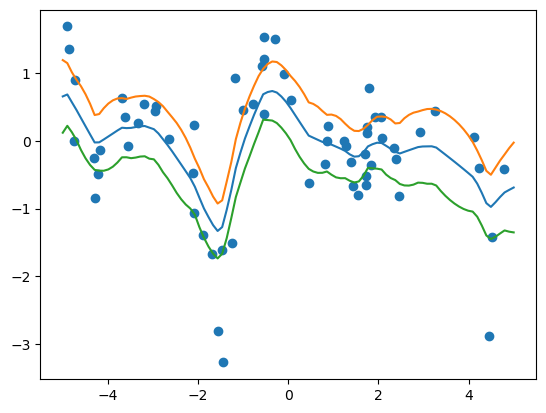

In [6]:
plt.scatter(x_train, y_train) 
plt.plot(x_values, mean)
plt.plot(x_values, mean + np.sqrt(np.diag(covariance)))
plt.plot(x_values, mean - np.sqrt(np.diag(covariance)))

In [20]:
burger1=np.append(x_values, x_values,0)
burger2=np.append(np.sin(x_values), np.sin(x_values) + np.ones(100),0)
bmean, bcov = gpr(burger1, x_values, burger2, s, sigma2)

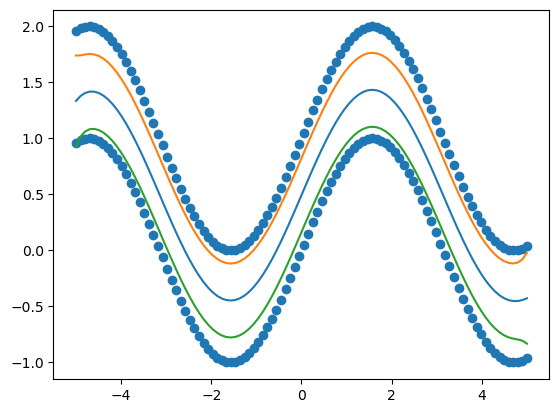

In [21]:
plt.scatter(burger1, burger2) 

plt.plot(x_values, bmean)
plt.plot(x_values, bmean + np.sqrt(np.diag(bcov)))
plt.plot(x_values, bmean - np.sqrt(np.diag(bcov)))

In [62]:
bmean

array([ 1.33529192,  1.37947609,  1.40632956,  1.41857949,  1.41801708,
        1.40587152,  1.38304781,  1.35027741,  1.30821289,  1.25748641,
        1.19874495,  1.13267024,  1.05998882,  0.98147542,  0.89795201,
        0.81028386,  0.71937347,  0.62615324,  0.53157709,  0.43661143,
        0.34222586,  0.2493835 ,  0.15903142,  0.07209109, -0.01055096,
       -0.08805207, -0.15962209, -0.22453133, -0.28211804, -0.33179514,
       -0.37305619, -0.40548054, -0.42873765, -0.44259041, -0.44689761,
       -0.44161532, -0.42679741, -0.40259493, -0.36925461, -0.32711633,
       -0.27660966, -0.21824949, -0.15263076, -0.08042242, -0.00236058,
        0.08075896,  0.16808886,  0.25873885,  0.35178479,  0.44627815,
        0.54125563,  0.635749  ,  0.72879494,  0.81944492,  0.90677482,
        0.98989437,  1.06795621,  1.14016455,  1.20578328,  1.26414345,
        1.31465011,  1.35678839,  1.39012871,  1.41433119,  1.4291491 ,
        1.43443138,  1.43012417,  1.41627139,  1.39301426,  1.36

In [39]:
def NLL(x, y, s, sigma2):
    n = np.size(x)
    x1v, x2v = np.meshgrid(x, x)
    xt = np.reshape(np.array([x1v,x2v]), (2, n**2)).T
    
    C = mkernel(xt[:,0], xt[:,1], s)
    lp = (1 / 2) * y.T @ np.linalg.inv(C) @ y + np.log(np.det(C)) + n * np.log(2 * np.pi())
    
    return lp

def grad_NLL(x, y, s, sigma2):
    n = np.size(x)
    
    x1v, x2v = np.meshgrid(x, x)
    xt = np.reshape(np.array([x1v,x2v]), (2, n**2)).T
    C = mkernel(xt[:,0], xt[:,1], s) + sigma2 * np.identity(n)
    dC_ds = (x2v - x1v) * C
    
    return dC_ds

In [46]:
x = grad_NLL(np.array([1,2,3]), np.array([1]), s, sigma2)

ValueError: operands could not be broadcast together with shapes (9,9) (3,3) 

In [52]:
def nkernel(x,xp,s):
    k = np.e**(-(1 / (2 * s**2)) * (x - xp)**2)
    return k

In [53]:
xw = np.linspace(-2,2,17)
X, Y = np.meshgrid(xw, xw)
nkernel(X, Y, 1)

array([[1.00000000e+00, 9.69233234e-01, 8.82496903e-01, 7.54839602e-01,
        6.06530660e-01, 4.57833362e-01, 3.24652467e-01, 2.16265167e-01,
        1.35335283e-01, 7.95595087e-02, 4.39369336e-02, 2.27941809e-02,
        1.11089965e-02, 5.08606923e-03, 2.18749112e-03, 8.83826307e-04,
        3.35462628e-04],
       [9.69233234e-01, 1.00000000e+00, 9.69233234e-01, 8.82496903e-01,
        7.54839602e-01, 6.06530660e-01, 4.57833362e-01, 3.24652467e-01,
        2.16265167e-01, 1.35335283e-01, 7.95595087e-02, 4.39369336e-02,
        2.27941809e-02, 1.11089965e-02, 5.08606923e-03, 2.18749112e-03,
        8.83826307e-04],
       [8.82496903e-01, 9.69233234e-01, 1.00000000e+00, 9.69233234e-01,
        8.82496903e-01, 7.54839602e-01, 6.06530660e-01, 4.57833362e-01,
        3.24652467e-01, 2.16265167e-01, 1.35335283e-01, 7.95595087e-02,
        4.39369336e-02, 2.27941809e-02, 1.11089965e-02, 5.08606923e-03,
        2.18749112e-03],
       [7.54839602e-01, 8.82496903e-01, 9.69233234e-01, 1.000

ValueError: cannot reshape array of size 34 into shape (2,289)

In [48]:
burger, burger2 = np.meshgrid(x_values, x_values)

In [132]:
NLL(x_train,y_train, s, sigma2)

LinAlgError: Singular matrix